In [2]:
"""
Author: Nils Weyrauch
Auswertung der Bevölkerungsinterpolation in Gridzellen

Maße:
MRSE (Mean Root Square Error) für die absoluten Bevölkerungszahlen pro Hektar
MAPE (Mean Absolute Percentage Error) für die prozentualen Abweichungen

Auswertungsschritte:
Filtern ungültiger Werte
1. Funktionen für Auswertungsmaße ganzes Gebiet
2. Funktionen für Auswertungsmaße Landkreise
3. Reklassifizieren der Abweichungen für Visualisierung
4. Grafiken für die Auswertung

Input Daten:
100m Grid Ug mit geschätzten Bevölkerungsdaten
"""

'\nAuthor: Nils Weyrauch\nAuswertung der Bevölkerungsinterpolation in Gridzellen\n\nMaße:\nMRSE (Mean Root Square Error) für die absoluten Bevölkerungszahlen pro Hektar\nMAPE (Mean Absolute Percentage Error) für die prozentualen Abweichungen\n\nAuswertungsschritte:\nFiltern ungültiger Werte\n1. Funktionen für Auswertungsmaße ganzes Gebiet\n2. Funktionen für Auswertungsmaße Landkreise\n3. Reklassifizieren der Abweichungen für Visualisierung\n4. Grafiken für die Auswertung\n\nInput Daten:\n100m Grid Ug mit geschätzten Bevölkerungsdaten\n'

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
"""
Berechnung des RMSE für das gesamte UG

Schritte:
1. Residuen berechnen
2. Residuen quadrieren
3. Mittelwert der quadrierten Residuen
4. Wurzel ziehen
"""

def calc_rmse(data, pred_val, act_val):

    # Residuen berechnen aus geschätzten und offiziellen Daten für jede Zelle
    data["res"] = data[pred_val] - data[act_val]

    # quadrieren der Residuen
    data["res_sq"] = data["res"]**2

    # Mittelwert der quadrierten Residuen für das ganze UG
    res_sq_m = data["res_sq"].mean()

    # Wurzel ziehen aus Mittelwert
    rmse = res_sq_m **0.5

    return rmse

In [5]:
"""
Berechnung des MAPE für das gesamte UG

Schritte:
1. prozentuale Abweichung aus absoluten Werten berechnen
2. Mittelwert bilden
"""

def calc_mape(data, pred_val, act_val):
   
    # Kalkulieren des prozentualen Fehlers, mittels der absoluten Werte 
    data["abs_perc_error"] = (abs(data[act_val] - data[pred_val]) / abs(data[act_val])) * 100
    
    # Mittelwert des Fehlers berechnen
    mape = data["abs_perc_error"].mean()
    
    return mape

In [6]:
"""
Berechnung des Mean absolute Error für das gesamte UG

Schritte:
1. Residuen berechnen
2. Mittelwert der Residuen
"""

def calc_mae(data, pred_val, act_val):

    # Residuen berechnen aus geschätzten und offiziellen Daten für jede Zelle
    data["res"] = abs(data[pred_val] - data[act_val])

    # Mittelwert der quadrierten Residuen für das ganze UG
    mae = data["res"].mean()

    return mae

In [7]:
"""
Berechnung des Mean Absolute Error pro GN_ID (Landkreis))
"""

def calc_mae_gn(data, pred_val, act_val, fieldname):

    # Residuen berechnen
    data["res"] = abs(data[pred_val] - data[act_val])

    # Daten nach LK gruppieren, Mittelwert der Residuen berechnen
    res_sq_m = data.groupby("GN_ID")["res"].mean().reset_index(name=fieldname)

    return mae_gn

In [8]:
"""
Berechnung des RMSE pro GN_ID (Landkreis))
"""

def calc_rmse_gn(data, pred_val, act_val, fieldname):

    # Residuen berechnen
    data["res"] = data[pred_val] - data[act_val]

    # Werte quadrieren
    data["res_sq"] = data["res"]**2

    # Daten nach LK gruppieren, Mittelwert der quadrierten Residuen berechnen, .pow(1./2) zieht die Wurzel
    res_sq_m = data.groupby("GN_ID")["res_sq"].mean().pow(1./2).reset_index(name=fieldname)

    return res_sq_m

In [9]:
"""
Berechnung des MAPE pro GN_ID (Landkreis))
"""

def calc_mape_gn(data, pred_val, act_val, fieldname, absolute_error_field):
    
    # Kalkulieren des prozentualen Fehlers, mittels der absoluten Werte
    data[absolute_error_field] = (abs(data[act_val] - data[pred_val]) / abs(data[act_val])) * 100
    
    # Daten nach LK gruppieren, Mittelwert des Fehlers berechnen
    mape = data.groupby("GN_ID")[absolute_error_field].mean().reset_index(name=fieldname)
    
    return mape

In [10]:
"""
Funktion zum Reklassifiezieren der prozentualen Fehlerwerte in Bewertungen

Aufbau:
1. Anlegen der neuen Spalte,
2. .loc Funktion festlegen, welche die Werte entsprechend des IP Felds reklassifiziert in Notenskala
"""

def recl_perc(gdf, relc_field, fieldname):

    # Anlegen der Reklassifizierten Nutzungsspalte
    gdf[fieldname] = " "

    # .loc Funktion greift auf Werte auf Basis der spezifizierten konditionen zu
    # und weist die entsprechenden neuen Werte zu

    gdf.loc[(gdf[relc_field] <= 5), fieldname] = "sehr gut"
    
    gdf.loc[(gdf[relc_field] > 5) & (gdf[relc_field] <= 10), fieldname] = "gut"
  
    gdf.loc[(gdf[relc_field] > 10) & (gdf[relc_field] <= 20), fieldname] = "befriediegend"

    gdf.loc[(gdf[relc_field] > 20) & (gdf[relc_field] <= 30), fieldname] = "ausreichend"

    gdf.loc[(gdf[relc_field] > 30) & (gdf[relc_field] <= 40), fieldname] = "mangelhaft"

    gdf.loc[gdf[relc_field] > 40, fieldname] = "ungenügend"
    
    return gdf

In [11]:
# Import der IP Daten aus letztem Skript und zusätzlichen Datensätzen für Visualisierung
grid = gpd.read_file(r"F:\Zwischendaten\grid_bev_abw_merge_2022.shp")

# import des UGs um Filterung von Gridzellen, welche teilweise aus dem UG fallen. Diese enthalten Bevölkerungsdaten auch aus anderen Kreisen und sind somit verzerrt
ip_kreise = gpd.read_file(r"F:\Basisdaten\dvg1krs_nw.shp", crs="EPSG:25832")
UG_kreise = ip_kreise[ip_kreise['GN'].isin([ "Ennepe-Ruhr-Kreis",  "Oberbergischer Kreis", "Wuppertal", "Remscheid" ])]

In [12]:
adr = gpd.read_file(r"F:\Zwischendaten\adr_point.shp",crs="EPSG:25832")

In [13]:
# Umwandeln der UG Landkreise in ihren Umriss
UG_union = UG_kreise.geometry.unary_union.boundary
UG = gpd.GeoDataFrame(geometry=[UG_union], crs="EPSG:25832")

In [14]:
# Filtern des GDF auf gültige Werte, in manchen Gridzellen ist Bevölkerung vorhanden aber keine Hausdaten zum Schätzen (ca. 1000), 27 Randzellen haben keine GN_ID zugewiesen
grid_filt = grid[(grid["House_Anz"] != 0) & (grid["GN_ID"].isin(["WU", "RS", "OBK", "ERK"]))]

In [15]:
# herausfiltern aller Kacheln die von Bevölkerungszahlen anderer Landkreise beeinflusst werden
# Liste erstellen mit allen Zellenindices, welche die Grenzen des UGs berühren (somit teilweise ausserhalb liegen)
UG_inters= UG.sjoin(grid_filt, how="inner", predicate="intersects")
index_UG = list(UG_inters["index_right"])

In [16]:
# herausfiltern aller Kacheln über die eben angefertigte Liste
grid_filt= grid_filt[~grid_filt.index.isin(index_UG)]

In [17]:
# Kalkulieren des RMSE für das gesamte UG, anhand der zwei verschiedenen Modell Schätzwerte
rmse_m = calc_rmse(grid_filt, "m_pred_bev", "Einwohner")
rmse_t = calc_rmse(grid_filt, "t_pred_bev", "Einwohner")

In [18]:
print(rmse_m, rmse_t)

14.662101819063912 15.553817654989606


In [19]:
# Mean Absolute Error berechnen 
mae_m = calc_mae(grid_filt,"m_pred_bev", "Einwohner")
mae_t = calc_mae(grid_filt,"t_pred_bev", "Einwohner")

In [20]:
print(mae_m), print(mae_t)

7.564236171285137
8.075660076111413


(None, None)

In [21]:
# Kalkulieren des MAPE für das komplette UG, anhand beider Schätzungen
mape_m = calc_mape(grid_filt, "m_pred_bev", "Einwohner")
mape_t = calc_mape(grid_filt, "t_pred_bev", "Einwohner")

In [22]:
print(mape_m, mape_t)

37.52924752079657 41.476873207997336


In [23]:
# Berechnung des MAPE pro LK und des absoluten prozentualen Fehlers für jede Gridzelle
mape_gn_t = calc_mape_gn(grid_filt, "t_pred_bev", "Einwohner", "MAPE_t", "t_abs_perc_error")
mape_gn_m = calc_mape_gn(grid_filt, "m_pred_bev", "Einwohner", "MAPE_m", "m_abs_perc_error")

In [24]:
# Berechnung des RMSE pro LK
rmse_gn_t = calc_rmse_gn(grid_filt, "t_pred_bev", "Einwohner", "RMSE_t")
rmse_gn_m = calc_rmse_gn(grid_filt, "m_pred_bev", "Einwohner", "RMSE_m")

In [25]:
# Mergen der verschiedenen Genauigkeitsmaße
error_matr = mape_gn_t.merge(mape_gn_m, on="GN_ID").merge(rmse_gn_m, on="GN_ID").merge(rmse_gn_t, on="GN_ID")

In [26]:
# Berechnung der Bevölkerung pro LK aus den offiziellen und geschätzten Daten
bev_lk = grid_filt.groupby("GN_ID")["Einwohner"].sum().reset_index(name="sum_bev_off")
bev_lk_calc = grid_filt.groupby("GN_ID")["m_pred_bev"].sum().reset_index(name="m_sum_bev_pred")
bev_lk_calc = bev_lk_calc.merge(bev_lk, on="GN_ID")
bev_lk_calc_t = grid_filt.groupby("GN_ID")["t_pred_bev"].sum().reset_index(name="t_sum_bev_pred")
bev_lk_calc = bev_lk_calc.merge(bev_lk_calc_t, on="GN_ID")

In [27]:
# Berechnung des prozentualen Unterschieds zwischen den Bevölkerungszahlen
bev_lk_calc["m_diff"] = (bev_lk_calc["m_sum_bev_pred"] -bev_lk_calc["sum_bev_off"])/bev_lk_calc["sum_bev_off"] * 100
bev_lk_calc["t_diff"] = (bev_lk_calc["t_sum_bev_pred"] -bev_lk_calc["sum_bev_off"])/bev_lk_calc["sum_bev_off"] * 100

In [28]:
# Mergen der Genauigkeitsmaße mit den Bevölkerungssummen
stats = bev_lk_calc.merge(error_matr, on="GN_ID")

In [29]:
# Export der Daten
stats.to_csv(r"F:\Ergebnis\statistiken_skript.csv")

In [30]:
#Berechnung der Bevölkerungszahlen für das komplette UG und die Abweichungen der Modellle
sum_bev_m = stats["m_sum_bev_pred"].sum() / stats["sum_bev_off"].sum()*100
sum_bev_t = stats["t_sum_bev_pred"].sum() / stats["sum_bev_off"].sum()*100

In [31]:
# Berechnung der geschätzten Bevölkerungszahlen für ganzen Landkreis und differenz zu offiziellen Daten
print(stats["t_sum_bev_pred"].sum())
print(stats["t_sum_bev_pred"].sum() - stats["sum_bev_off"].sum())
print(stats["sum_bev_off"].sum())

1154577.3225526076
108211.32255260763
1046366


In [32]:
print(sum_bev_m)
print(sum_bev_t)

104.56736551300638
110.34163213948156


In [33]:
# Reklassifizieren der absoluten prozentualen Fehler für spätere Visualisierung nach Schulnotensystem
grid_recl = recl_perc(grid_filt, "t_abs_perc_error", "t_abs_Abw_recl")
grid_recl = recl_perc(grid_filt, "m_abs_perc_error", "m_abs_Abw_recl")

In [34]:
# Häufigkeit der Klassen zählen
counts_t = grid_recl["t_abs_Abw_recl"].value_counts().reset_index(name="count_t")
counts_m = grid_recl["m_abs_Abw_recl"].value_counts().reset_index(name="count_m")

In [35]:
# Umrechnen der Anzahl des bewerteten aboluten Fehlers in prozentuale Anteile für das Gesamte UG
counts_t["perc_t"] = counts_t["count_t"]/ counts_t["count_t"].sum() *100
counts_t["perc_t"] = counts_t["perc_t"].round(2)

counts_m["perc_m"] = counts_m["count_m"]/ counts_m["count_m"].sum() *100
counts_m["perc_m"] = counts_m["perc_m"].round(2)

In [36]:
print(counts_m)
print(counts_m["count_m"].sum())

  m_abs_Abw_recl  count_m  perc_m
0     ungenügend     8975   27.05
1  befriediegend     7120   21.46
2    ausreichend     5227   15.76
3       sehr gut     4156   12.53
4            gut     4099   12.36
5     mangelhaft     3598   10.85
33175


In [37]:
print(counts_t)

  t_abs_Abw_recl  count_t  perc_t
0     ungenügend    10143   30.57
1  befriediegend     6782   20.44
2    ausreichend     5005   15.09
3       sehr gut     3943   11.89
4            gut     3853   11.61
5     mangelhaft     3449   10.40


In [38]:
# Zählen des bewerteten absoluten Fehlers pro LK, wie viele Kacheln jeder Klasse zugeordnet sind
counts_GN_t = grid_recl.groupby("GN_ID")["t_abs_Abw_recl"].value_counts().reset_index(name="t_count")
counts_GN_m = grid_recl.groupby("GN_ID")["m_abs_Abw_recl"].value_counts().reset_index(name="m_count")

In [39]:
# Prozentualen Anteil des bewerteten Absoluten Fehlers pro LK ermitteln, Ergebnis auf 2 Nachkommastellen runden
counts_GN_t["t_GN_perc"] = counts_GN_t["t_count"] / counts_GN_t.groupby("GN_ID")["t_count"].transform("sum") * 100
counts_GN_t["t_GN_perc"] = counts_GN_t["t_GN_perc"].round(2)

counts_GN_m["m_GN_perc"] = counts_GN_m["m_count"] / counts_GN_m.groupby("GN_ID")["m_count"].transform("sum") * 100
counts_GN_m["m_GN_perc"] = counts_GN_m["m_GN_perc"].round(2)

In [40]:
# Zu Übersichtszwecken die Datenreihe in eine Pivot Tabelle formatieren
piv_GN_perc_t = counts_GN_t.pivot_table(index="GN_ID", columns="t_abs_Abw_recl", values="t_GN_perc", sort=False)

piv_GN_perc_m = counts_GN_m.pivot_table(index="GN_ID", columns="m_abs_Abw_recl", values="m_GN_perc", sort=False)

In [41]:
# Pivot Tablle nach güte der Interpolation sortieren
piv_sort_t = piv_GN_perc_t.reindex(columns=["sehr gut", "gut", "befriediegend", "ausreichend", "mangelhaft", "ungenügend"])

piv_sort_m = piv_GN_perc_m.reindex(columns=["sehr gut", "gut", "befriediegend", "ausreichend", "mangelhaft", "ungenügend"])

In [42]:
# Ermitteln des prozentualen Anteil des UG, welcher über bzw. unterschätzt wird
positive_m = grid_filt[grid_filt["dif_bev_m"] > 0].shape[0] /33175 *100
negative_m = grid_filt[grid_filt["dif_bev_m"] < 0].shape[0] /33175 *100

In [43]:
# Anteile der über und unterschätzten Zellen im Ug anzeigen und Kategorien zählen für das Mean Modell
print(positive_m)
print(negative_m)
print(grid_filt[grid_filt["dif_bev_m"] > 0].shape[0])
print(grid_filt[grid_filt["dif_bev_m"] < 0].shape[0])

42.65561416729465
57.34438583270535
14151
19024


In [44]:
# Ermittlung der prozentualen Anteile an Kacheln, die pro Gemeinde unter bzw. überschätzt werden
positive_gn_m = grid_filt[grid_filt["dif_bev_m"] > 0].groupby("GN_ID").size() / grid_filt.groupby("GN_ID").size() *100
negative_gn_m = grid_filt[grid_filt["dif_bev_m"] < 0].groupby("GN_ID").size() / grid_filt.groupby("GN_ID").size() *100

In [45]:
print(positive_gn_m)
print(negative_gn_m)

GN_ID
ERK    38.445586
OBK    47.105562
RS     42.503864
WU     39.560094
dtype: float64
GN_ID
ERK    61.554414
OBK    52.894438
RS     57.496136
WU     60.439906
dtype: float64


In [46]:
# Anteile der über und unterschätzten Zellen im Ug anzeigen und Kategorien zählen für das Trained Modell
positive_t = grid_filt[grid_filt["dif_bev_t"] > 0].shape[0] /33175 *100
negative_t = grid_filt[grid_filt["dif_bev_t"] < 0].shape[0] /33175 *100
print(positive_t)
print(negative_t)

36.29540316503391
63.70459683496609


In [47]:
# Ermittlung der prozentualen Anteile an Kacheln, die pro Gemeinde unter bzw. überschätzt werden für trained Modell
positive_gn_t = grid_filt[grid_filt["dif_bev_t"] > 0].groupby("GN_ID").size() / grid_filt.groupby("GN_ID").size() *100
negative_gn_t = grid_filt[grid_filt["dif_bev_t"] < 0].groupby("GN_ID").size() / grid_filt.groupby("GN_ID").size() *100
print(positive_gn_t)
print(negative_gn_t)

GN_ID
ERK    38.455461
OBK    34.314699
RS     43.199382
WU     34.438335
dtype: float64
GN_ID
ERK    61.544539
OBK    65.685301
RS     56.800618
WU     65.561665
dtype: float64


In [48]:
# reklassifierung der Abweichung in Über und Unterschätzung, negative Werte zeigen an, dass die offizielle Zahl niedriger ist, positive, dass sie größer ist
grid_recl.loc[grid_recl["dif_bev_m"] < 0, "Schätzung-M"] = "Überschätzung"
grid_recl.loc[grid_recl["dif_bev_m"] > 0, "Schätzung-M"] = "Unterschätzung"
grid_recl.loc[grid_recl["dif_bev_t"] < 0, "Schätzung-T"] = "Überschätzung"
grid_recl.loc[grid_recl["dif_bev_t"] > 0, "Schätzung-T"] = "Unterschätzung"

In [49]:
# Datenvisualisierung

In [50]:
#Workaroud um den Legendentitel ohne Fehler zu setzen
counts_GN_t["Bewertungslabel"] = counts_GN_t["t_abs_Abw_recl"]
counts_GN_m["Bewertungslabel"] = counts_GN_m["m_abs_Abw_recl"]

In [51]:
#Workaroud um den Legendentitel ohne Fehler zu setzen
grid_filt["Landkreis"] = grid_filt["GN_ID"]

In [52]:
#Workaroud um den Legendentitel ohne Fehler zu setzen
adr["Klasse"] = adr["PREDICTED"].astype(int)

In [53]:
# Neubennunng von Hausklassen für Visualisierung
grid_filt["dominante Hausklasse"] = grid_filt["dom_class"].replace({ "1" :"EFZH-EH", "2" : "EFZH-DH", "3":"EFZH-RH", "5" : "MFH-F", "6" : "MFH-TZ", "7" : "MFH-IZ", "8" : "MFH-G"})

In [54]:
adr["Hausklasse"] =  adr["Klasse"].replace({ 1 :"EFZH-EH", 2 : "EFZH-DH", 3:"EFZH-RH", 5 : "MFH-F", 6 : "MFH-TZ", 7 : "MFH-IZ", 8 : "MFH-G"})

In [55]:
# festlegen von Reihenfolgen in denen Klassen geplotted werden sollen
hue_order_bewertung = ["sehr gut", "gut", "befriediegend", "ausreichend", "mangelhaft", "ungenügend"]

In [56]:
haus_order = ["EFZH-EH","EFZH-DH", "EFZH-RH", "MFH-F", "MFH-TZ", "MFH-IZ", "MFH-G"]

In [57]:
order_dom_class = ["1", "2","3","5","6","7","8"]

Text(47.20515277777777, 0.5, 'Prozentuale Anteile')

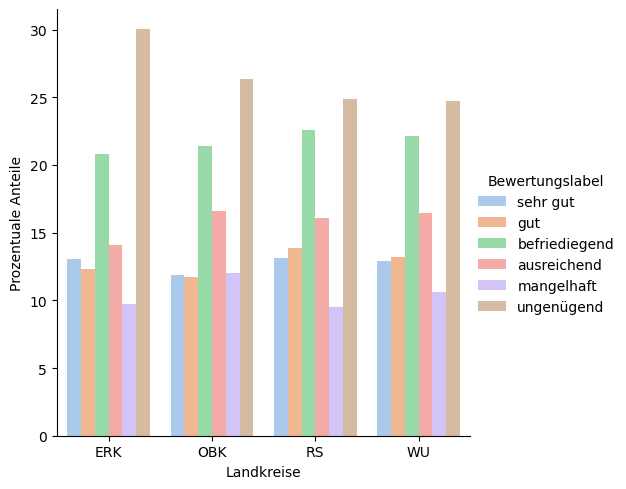

In [58]:
# Plotten der klassifierten Prozentualen Anteile pro Landkreis, Mean Modell

cat_plot_perc_m = sns.catplot(data=counts_GN_m,y="m_GN_perc", x="GN_ID",  hue="Bewertungslabel", kind="bar", hue_order=hue_order_bewertung, palette="pastel")
plt.xlabel( "Landkreise")
plt.ylabel("Prozentuale Anteile")

Text(47.20515277777777, 0.5, 'Prozentuale Anteile')

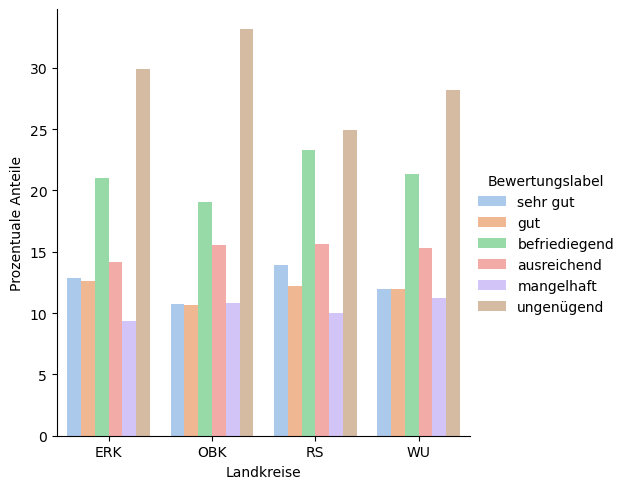

In [59]:
# Plotten der klassifierten Prozentualen Anteile pro Landkreis, Trained Modell
cat_plot_perc_t = sns.catplot(data=counts_GN_t,y="t_GN_perc", x="GN_ID",  hue="Bewertungslabel", kind="bar", hue_order=hue_order_bewertung, palette="pastel")
plt.xlabel( "Landkreise")
plt.ylabel("Prozentuale Anteile")

In [60]:
# festlegen neuer Spalte, die erlaubt alle Daten einzufärben, ansonsten meckert Seaborn bei der Farbpalette
grid_filt["Farbe"] = 1

Text(0.5, 0, 'Einwohner pro Gridzelle')

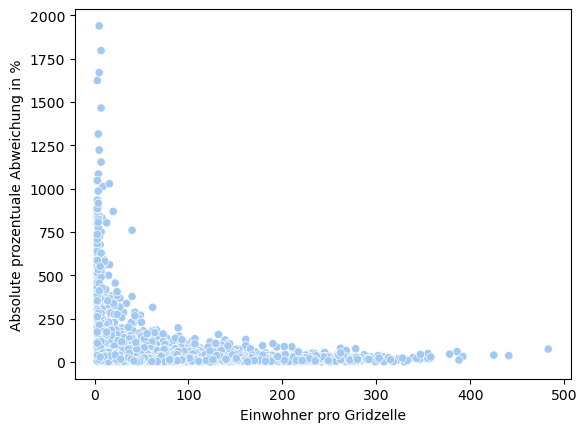

In [61]:
# Scatterplot für den Zusammenhang zwischen Abweichungen und Einwohneranzahl
scatter = sns.scatterplot(data=grid_filt, x="Einwohner", y="m_abs_perc_error", palette="pastel", hue="Farbe", legend=False )

plt.ylabel("Absolute prozentuale Abweichung in %")
plt.xlabel("Einwohner pro Gridzelle")

Text(0, 0.5, 'Absolute prozentuale Abweichung in %')

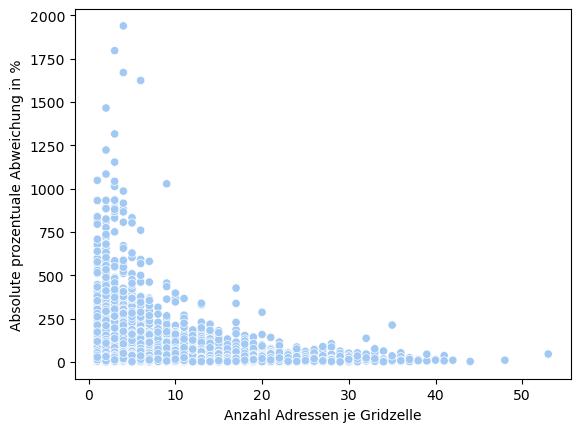

In [62]:
# Scatterplot für den Zusammenhang zwischen Fehler und Adressenzahl
scatteradr = sns.scatterplot(data=grid_filt, x="House_Anz", y="m_abs_perc_error", hue="Farbe", palette="pastel", legend=False)
plt.xlabel("Anzahl Adressen je Gridzelle")
plt.ylabel("Absolute prozentuale Abweichung in %")

In [63]:
# Zusmmenführen der Error spalten beider Modelle um nebeneinander visualisieren zu können
abs_error_melt = pd.melt(grid_filt, value_vars=["m_abs_perc_error", "t_abs_perc_error"], var_name="Modell", value_name="Absoluter Prozentualer Fehler")
abs_error_melt["Modell"] = abs_error_melt["Modell"].replace({"m_abs_perc_error" : "Mean", "t_abs_perc_error" : "Trained"})

Text(0.5, 0, 'Modellvariante')

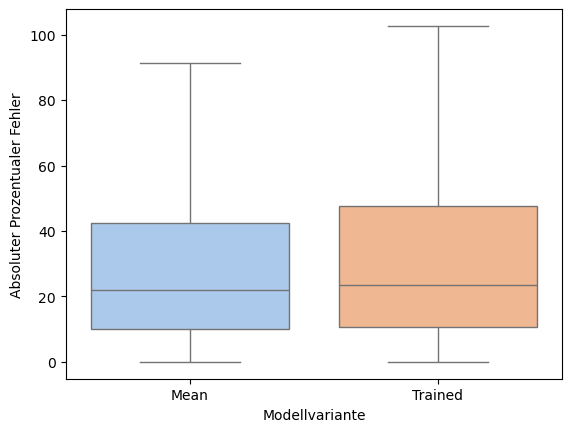

In [64]:
# Vergelich der Fehler beider Modelle nebeneinander
box_abs_err = sns.boxplot(data=abs_error_melt, x='Modell', y='Absoluter Prozentualer Fehler', hue="Modell", palette="pastel", whis=1.5, showfliers=False)
plt.xlabel("Modellvariante")

In [65]:
# Statistische Merkmale der Datensätze für Auswertung
grid_filt["m_abs_perc_error"].describe()

count    33175.000000
mean        37.529248
std         61.456716
min          0.000397
25%         10.044390
50%         21.986452
75%         42.565801
max       1937.908548
Name: m_abs_perc_error, dtype: float64

In [66]:
grid_filt["t_abs_perc_error"].describe()

count    33175.000000
mean        41.476873
std         68.129352
min          0.001675
25%         10.705366
50%         23.634083
75%         47.491345
max       2318.780130
Name: t_abs_perc_error, dtype: float64

C:\Users\Nils\AppData\Local\Temp\ipykernel_19808\1457967941.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_GN_abs_m = sns.boxplot(data=grid_filt, x='GN_ID', y='m_abs_perc_error', native_scale=False, whis=1.5, showfliers=False, palette="pastel")


Text(0.5, 0, 'Landkreis')

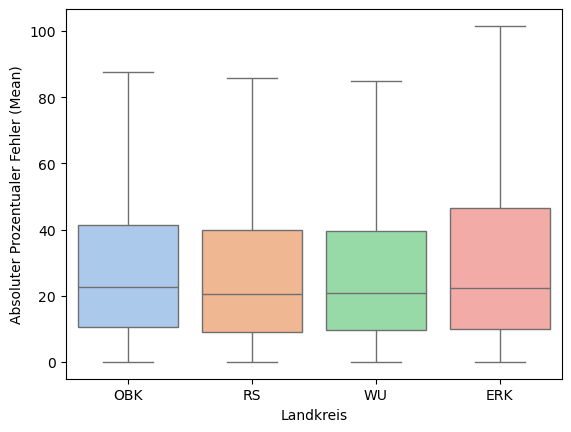

In [67]:
# Boxplot um Fehler pro Landkreis zu vergleichen, Mean Modell
box_GN_abs_m = sns.boxplot(data=grid_filt, x='GN_ID', y='m_abs_perc_error', native_scale=False, whis=1.5, showfliers=False, palette="pastel")
plt.ylabel("Absoluter Prozentualer Fehler (Mean)")
plt.xlabel("Landkreis")

Text(0.5, 0, 'Landkreis')

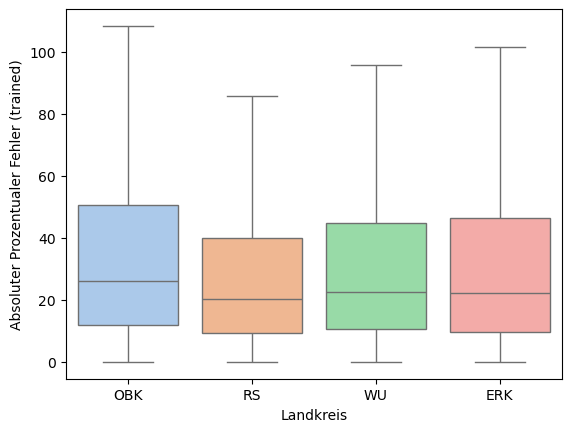

In [68]:
# Boxplot um Fehler pro Landkreis zu vergleichen, Trained Modell
box_GN_abs_t = sns.boxplot(data=grid_filt, x='GN_ID', y='t_abs_perc_error', native_scale=False, whis=1.5, showfliers=False,hue="GN_ID" , palette="pastel")
plt.ylabel("Absoluter Prozentualer Fehler (trained)")
plt.xlabel("Landkreis")

Text(0, 0.5, 'Absoluter prozentualer Fehler (Mean)')

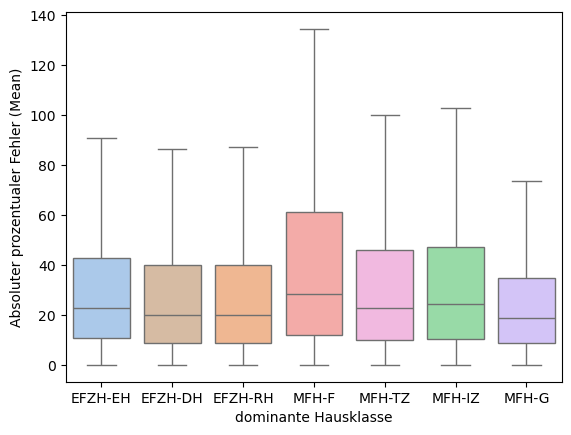

In [69]:
# Plotten von Abweichungen  pro Häuserklasse, Mean Modell
box_dom_class_abs_m = sns.boxplot(data=grid_filt, x="dominante Hausklasse", y='m_abs_perc_error', native_scale=False, whis=1.5, showfliers=False, hue="dominante Hausklasse", palette="pastel", order=haus_order)
plt.ylabel("Absoluter prozentualer Fehler (Mean)")

Text(0, 0.5, 'Absoluter prozentualer Fehler (Trained)')

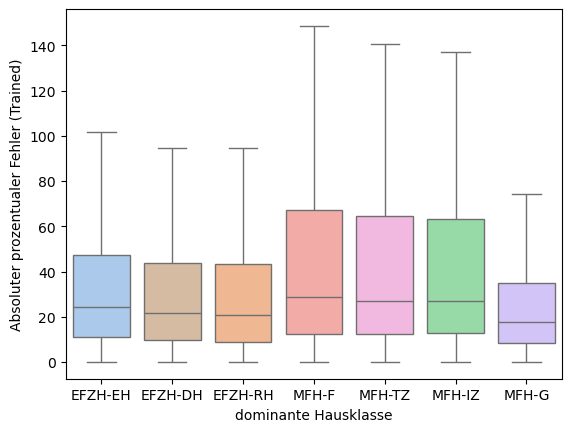

In [70]:
# Plotten von Abweichungen  pro Häuserklasse, Trained Modell
box_dom_class_abs_t = sns.boxplot(data=grid_filt, x="dominante Hausklasse", y='t_abs_perc_error', native_scale=False, whis=1.5, showfliers=False, hue="dominante Hausklasse", palette="pastel", order=haus_order)
plt.ylabel("Absoluter prozentualer Fehler (Trained)")

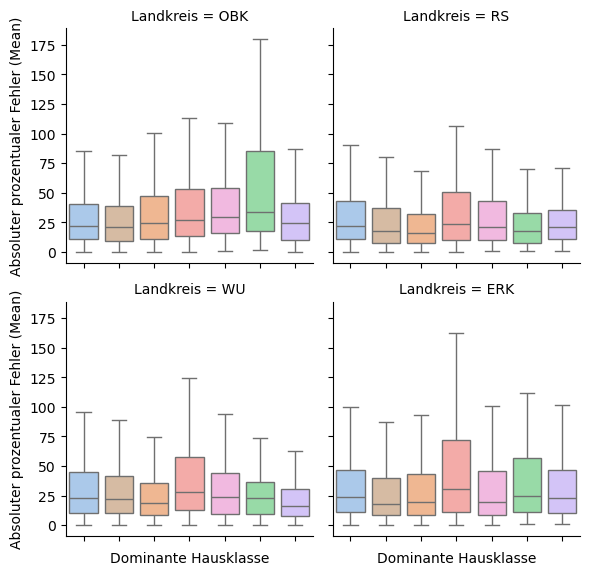

In [71]:
# Unterschiede Fehler Hausklasse für jeden Landkreis ´, Mean Modell

g = sns.FacetGrid(grid_filt, col="Landkreis", margin_titles=True, col_wrap=2)
g.map_dataframe(sns.boxplot, "dom_class", "m_abs_perc_error",showfliers=False, order=order_dom_class, hue="dom_class", palette="pastel", hue_order=["1","3","7","5","8","2","6"])
g.set_axis_labels("Dominante Hausklasse", "Absoluter prozentualer Fehler (Mean)")

for ax in g.axes.flatten():
    ax.set_xticklabels([])

C:\Users\Nils\anaconda3\envs\geopandas\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Nils\anaconda3\envs\geopandas\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Nils\anaconda3\envs\geopandas\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Nils\anaconda3\envs\geopandas\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Pass

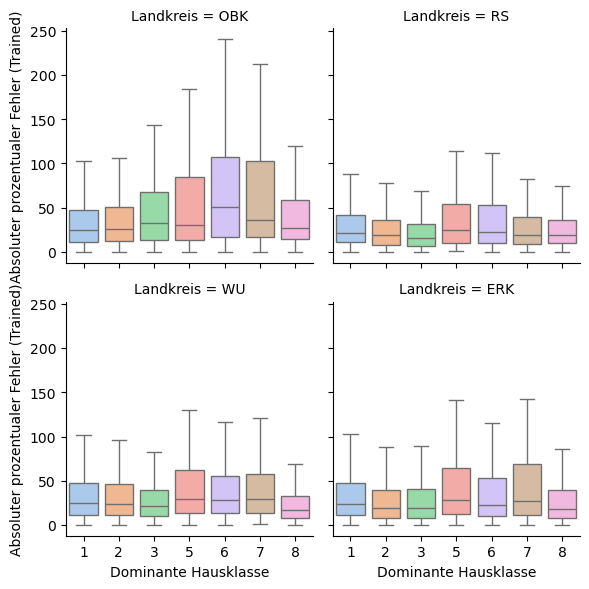

In [72]:
# Unterschiede Fehler Hausklasse für jeden Landkreis ´, Trained Modell
g2 = sns.FacetGrid(grid_filt, col="Landkreis", margin_titles=True, col_wrap=2)
g2.map(sns.boxplot, "dom_class", "t_abs_perc_error",showfliers=False, palette="pastel", order=order_dom_class)
g2.set_axis_labels("Dominante Hausklasse", "Absoluter prozentualer Fehler (Trained)")

Text(0, 0.5, 'Anzahl')

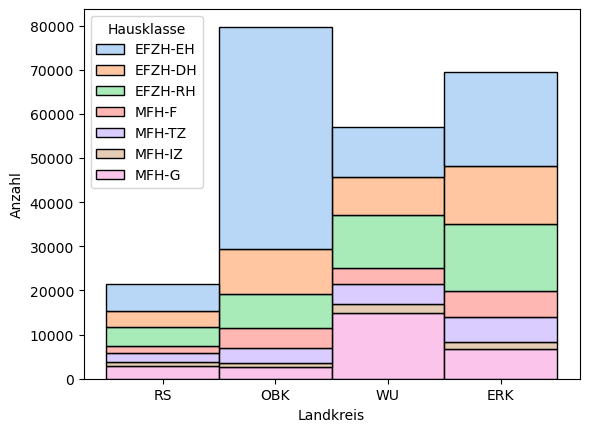

In [73]:
# Vergleich der Klassenanzahl pro Landkreis
bar_count_class = sns.histplot(data=adr, x='GN_ID', hue="Hausklasse",palette="pastel", multiple="stack", hue_order=haus_order)
plt.xlabel("Landkreis")
plt.ylabel("Anzahl")

Text(0, 0.5, 'Anteil')

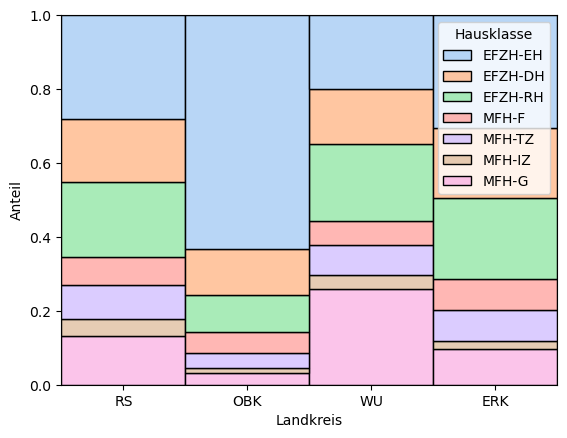

In [74]:
# Klassenanteile pro Landkreis, für Häuserkategorien
bar_normalized_class = sns.histplot(data=adr, x='GN_ID', hue="Hausklasse",palette="pastel", multiple="fill", hue_order=haus_order)
plt.xlabel("Landkreis")
plt.ylabel("Anteil")

In [75]:
# Zusammenführen alller Bevölkerungszahlen in eine Variable (Bevölkerungsschätzung), um diese in einem Diagramm darstellen zu können
Bev_melted = pd.melt(stats, id_vars=['GN_ID'], value_vars=["m_sum_bev_pred", "t_sum_bev_pred", "sum_bev_off"], 
                    var_name='Bevölkerungschätzung', value_name='Bevölkerungszahl')


In [76]:
# Umbennen der Modelle für die Darstellung im Diagramm
Bev_melted["Bevölkerungschätzung"] = Bev_melted["Bevölkerungschätzung"].replace({"m_sum_bev_pred" : "Mean", "sum_bev_off" : "Offiziell", "t_sum_bev_pred" : "Trained"})        

Text(0.5, 28.999999999999986, 'Landkreise')

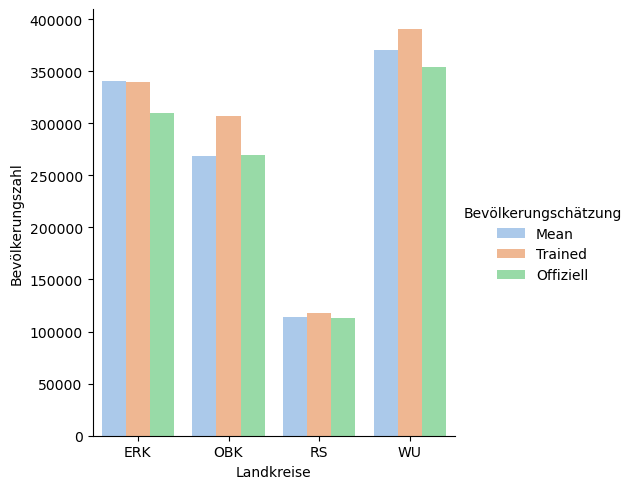

In [77]:
stats_bev = sns.catplot(data=Bev_melted,y="Bevölkerungszahl", x="GN_ID",  hue="Bevölkerungschätzung", kind="bar", palette="pastel")
plt.xlabel( "Landkreise")

Text(0.5, 0, 'geschätzte Einwohner (Mean) pro Hektar')

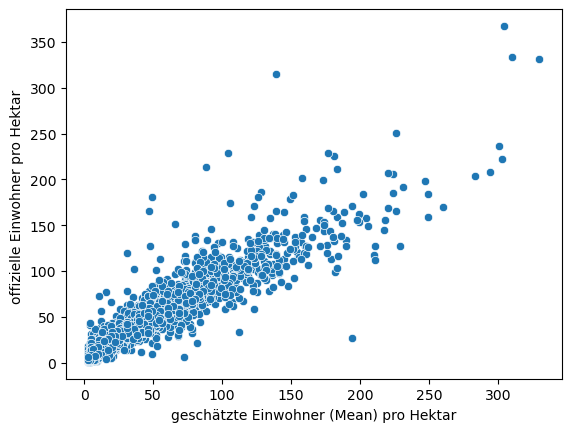

In [78]:
# Scatter geschätze Einwohner gegenüber offiziellen Einwohnern
scatter_obs_pred_m = sns.scatterplot(data=grid_filt[grid_filt["GN_ID"] == "RS"], x="Einwohner", y="m_pred_bev")

plt.ylabel("offizielle Einwohner pro Hektar ")
plt.xlabel("geschätzte Einwohner (Mean) pro Hektar")

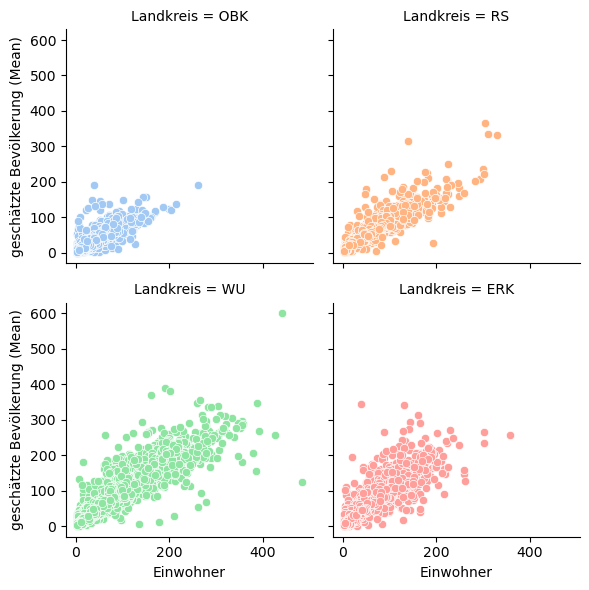

In [79]:
# Scatter geschätze Einwohner gegenüber offiziellen Einwohnern pro Landkreis
g = sns.FacetGrid(grid_filt, col="Landkreis", margin_titles=True, col_wrap=2, hue="GN_ID", palette="pastel")
g.map(sns.scatterplot, "Einwohner", "m_pred_bev")
g.set_ylabels( "geschätzte Bevölkerung (Mean)")

In [80]:
grid_filt.to_file(r"F:\Ergebnis\grid_final.shp", encoding='utf-8')

C:\Users\Nils\AppData\Local\Temp\ipykernel_19808\3774442336.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_filt.to_file(r"F:\Ergebnis\grid_final.shp", encoding='utf-8')
